# Imports

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from flair.models import TextClassifier
from flair.data import Sentence
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

In [2]:
# reading 2 parts only, to work on bigger dataset change file_list
dfs = []
file_list = [f'dataset/part-0{i}.json' for i in range(1,3)]
for i, file in enumerate(file_list):
    print(f'Reading file 0{i+1}....')
    data = pd.read_json(file) # read data frame from json file
    dfs.append(data) # append the data frame to the list

df = pd.concat(dfs) 

Reading file 01....
Reading file 02....


In [3]:
df.shape

(2022505, 9)

In [4]:
df.head(5)

,review_id,reviewer,movie,rating,review_summary,review_date,spoiler_tag,review_detail,helpful
0,rw5704482,raeldor-96879,After Life (2019– ),9.0,Very Strong Season 2,3 May 2020,0,"I enjoyed the first season, but I must say I t...","[1, 1]"
1,rw5704483,dosleeb,The Valhalla Murders (2019– ),6.0,Icelandic detectives?,3 May 2020,0,I know Iceland is a small country and police d...,"[2, 2]"
2,rw5704484,brightconscious,Special OPS (2020– ),7.0,Nothing special,3 May 2020,0,"Except K K , no other actor looks comfortable ...","[0, 0]"
3,rw5704485,gasconyway,#BlackAF (2020– ),8.0,Good but,3 May 2020,0,I'm guessing that as a 62 year old white woman...,"[5, 9]"
4,rw5704487,mmason-15867,The Droving (2020),2.0,An honest review,3 May 2020,0,Here's the truth. There's not much to this mov...,"[26, 41]"


In [3]:
# keeping only review and ratings column
df.drop(columns=['review_id','reviewer', 'movie', 'review_summary',	'review_date', 'spoiler_tag', 'helpful'], inplace=True)

In [6]:
df.isna().sum()

rating           114980
review_detail         0
dtype: int64

In [4]:
# drop nan ratings
df.dropna(axis=0, inplace=True)

<AxesSubplot:ylabel='Frequency'>

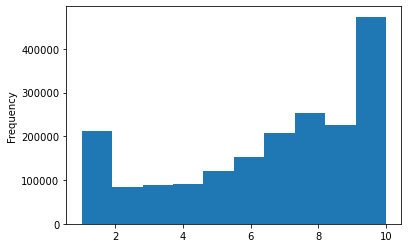

In [8]:
df['rating'].plot(kind='hist')

In [9]:
df['rating'].describe()

count    1.907525e+06
mean     6.691925e+00
std      3.056878e+00
min      1.000000e+00
25%      5.000000e+00
50%      7.000000e+00
75%      9.000000e+00
max      1.000000e+01
Name: rating, dtype: float64

In [5]:
# rating > 6 gets positive sentiment i.e. 1 and raing < 5 gets negative sentiment i.e. 0
def binary_rating(rating):
    if int(rating) > 6:
        return 1
    elif int(rating) < 5:
        return 0
    else:
        return np.nan
    
df['rating'] = df['rating'].apply(binary_rating)

In [6]:
df.dropna(inplace=True)
df.rename(columns={'review_detail': 'review'}, inplace=True)
df = df[['review','rating']]
df.reset_index(drop=True, inplace=True)

In [12]:
df.dtypes

review     object
rating    float64
dtype: object

In [7]:
df = df.astype({"rating": np.uint8})
df.dtypes

review    object
rating     uint8
dtype: object

In [29]:
df.head(5)

,review,rating
0,"I enjoyed the first season, but I must say I t...",1
1,"Except K K , no other actor looks comfortable ...",1
2,I'm guessing that as a 62 year old white woman...,1
3,Here's the truth. There's not much to this mov...,0
4,Having seen this film for the first time today...,1


In [15]:
pos = df[df['rating'] == 1].shape[0]/ df.shape[0] * 100
neg = df[df['rating'] == 0].shape[0]/ df.shape[0] * 100
print(f'Positive sentiment review %age: {pos} %')
print(f'Negative sentiment review %age: {neg} %')

Positive sentiment review %age: 70.92012071572427 %
Negative sentiment review %age: 29.079879284275734 %


# Preprocessing

In [15]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [16]:
def clean_review(review):
    
    # remove non-alphabets
    alpha_only = re.sub("[^a-zA-Z]", " ", review)
    lower = alpha_only.lower()
    words = lower.split()
    stop = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    # remove stop words and lemmatize each word 
    meaningful_words  = [lemmatizer.lemmatize(word) for word in words if word not in stop]
    return ' '.join(meaningful_words)

In [36]:
print(df.iloc[9770,0])
print('---------------------')
print(clean_review(df.iloc[9770,0]))

"Stalker" is a work that amazes people with many memories and keeps its freshness even today. It is a film that has been ignored at the grand prize ceremony and has been criticized by the Soviet regime. But it deserves to be called one of the director's most daring films to the end. Regardless of whether or not you agree with Tarkovsky's career that has been overwhelmed with faith in the world at times, the sense of admiration created by the film's grand finale never loses its effect. Even years later.
---------------------
stalker work amazes people many memory keep freshness even today film ignored grand prize ceremony criticized soviet regime deserves called one director daring film end regardless whether agree tarkovsky career overwhelmed faith world time sense admiration created film grand finale never loses effect even year later


In [12]:
# apply preprocessing to entire dataframe
df['review'] = df['review'].apply(clean_review)

In [13]:
# save the dataframe 
df.to_csv('dataset/clean_reviews.csv', encoding='utf-8', index=False)

In [18]:
# to load the cleaned dataset
df = pd.read_csv('dataset/clean_reviews.csv')

In [19]:
df.head(5)

,review,rating
0,enjoyed first season must say think season eve...,1
1,except k k actor look comfortable acting fight...,1
2,guessing year old white woman target demograph...,1
3,truth much movie sucked high rating overly pos...,0
4,seen film first time today year release still ...,1


In [8]:
# train on 75% and test on 25% 
from sklearn.model_selection import train_test_split
x = df['review']
y = df['rating']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

In [21]:
len(x_train)

1225192

In [19]:
len(x_test)

408398

In [25]:
# convert reviews from object to string (use only if cleaned dataset is loaded)
x_test = x_test.astype(str)
x_train = x_train.astype(str)

# TextBlob and VADER

## TextBlob

In [42]:
# use TextBlob to get sentiment of review
def blob_sentiment(review):
    
    #polarity ranges between [-1,1], -1 is negative sentiment and +1 is positive sentiment
    polarity = TextBlob(review).sentiment.polarity
    if polarity >= 0:
        return 1
    return 0

In [43]:
predictions = x_test.apply(lambda x : blob_sentiment(x))
accuracy_score(predictions,y_test)

0.7979911752750993

In [45]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.73      0.49      0.59    118938
           1       0.82      0.92      0.87    289460

    accuracy                           0.80    408398
   macro avg       0.77      0.71      0.73    408398
weighted avg       0.79      0.80      0.78    408398



## VaderSentiment

In [ ]:
analyzer = SentimentIntensityAnalyzer()

# use VADER to get sentiment of review
def vader_sentiment(review):
    
    # returns dict containing negative, neutral and positive probabilities,
    # also compound score normalized to be between -1 (most extreme negative) and +1 (most extreme positive)
    vs = analyzer.polarity_scores(review)
    return int(vs.get("compound")>0)

In [51]:
predictions = x_test.apply(lambda x : vader_sentiment(x))
accuracy_score(predictions,y_test)

0.7645874857369527

In [52]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.61      0.52      0.56    118938
           1       0.82      0.86      0.84    289460

    accuracy                           0.76    408398
   macro avg       0.71      0.69      0.70    408398
weighted avg       0.76      0.76      0.76    408398



## Generating wordcloud (skip this)

In [17]:
num_reviews = len(x_train.index)
train_reviews = []

for i in range(0, num_reviews):                                                                 
    train_reviews.append(x_train.iloc[i])

In [18]:
import scipy.sparse
vectorizer = CountVectorizer(analyzer = "word", lowercase=False,
                             max_features = 5000) 
train_data_features = vectorizer.fit_transform(train_reviews)
train_data_features = train_data_features.toarray()

In [24]:
train_data_features.shape

(619227, 5000)

In [27]:
dist = np.sum(train_data_features, axis=0)

In [43]:
vocab = vectorizer.get_feature_names()
zipper = zip(vocab, dist)
l = list(zipper)
l = sorted(l, key= lambda x: x[1], reverse=True)
for tag, count in l[0:10]:
    print(count, tag)

719117 movie
538979 film
378949 one
325224 like
267595 character
264963 story
259890 good
255753 time
228457 show
206855 really


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [45]:
word_freq = dict(l)

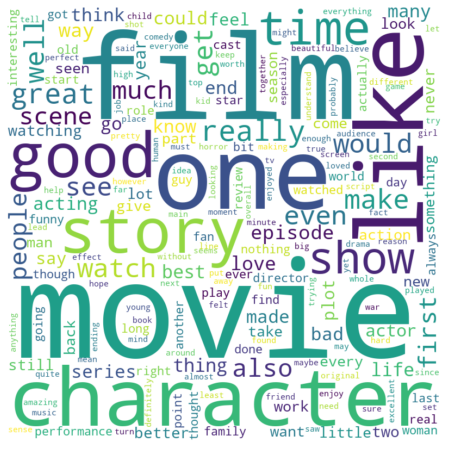

In [48]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

word_dict = dict(word_freq)

# Create a wordcloud object
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white').generate_from_frequencies(word_dict)

# Plot the wordcloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.tight_layout(pad = 0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Word2Vec

In [9]:
import nltk.data
from tqdm import tqdm

In [10]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [67]:
def clean_review(review, remove_stopwords=False):
    
    # remove non-alphabets
    alpha_only = re.sub("[^a-zA-Z]", " ", review)
    lower = alpha_only.lower()
    words = lower.split()
    lemmatizer = WordNetLemmatizer()
    
    stop = set(stopwords.words('english'))
    
    # remove stop words 
    if remove_stopwords:
        meaningful_words  = [word for word in words if word not in stop]
    else:
        meaningful_words = [word for word in words]
    return meaningful_words

In [56]:
# Define a function to split a review into parsed sentences
def review_to_sentences(review, tokenizer):
    # Function to split a review into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append(clean_review(raw_sentence))
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

In [ ]:
list_of_lists = []  # Initialize an empty list of sentences

for i in tqdm(range(len(x_train.index))):
    list_of_lists += review_to_sentences(x_train.iloc[i], tokenizer)

 11%|█         | 132105/1225192 [04:12<37:21, 487.61it/s]

In [63]:
print(len(list_of_lists))
print(list_of_lists[1])

9339648
['it', 'should', 'have', 'been', 'the', 'opposite', 'first', 'movie', 'wa', 'not', 'very', 'miike', 'like']


In [44]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 100   # Minimum word count                        
num_workers = 16       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-4   # Downsample setting for frequent words

In [64]:
# Initialize and train the model (this will take some time)
from gensim.models import word2vec
model = word2vec.Word2Vec(list_of_lists, workers=num_workers, \
            vector_size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "300features_100minwords_10context"
model.save(model_name)

2023-02-12 11:55:48,005 : INFO : collecting all words and their counts
2023-02-12 11:55:48,015 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-02-12 11:55:48,255 : INFO : PROGRESS: at sentence #10000, processed 194996 words, keeping 14239 word types
2023-02-12 11:55:48,408 : INFO : PROGRESS: at sentence #20000, processed 397342 words, keeping 20609 word types
2023-02-12 11:55:48,533 : INFO : PROGRESS: at sentence #30000, processed 603065 words, keeping 25477 word types
2023-02-12 11:55:48,632 : INFO : PROGRESS: at sentence #40000, processed 809280 words, keeping 29766 word types
2023-02-12 11:55:48,750 : INFO : PROGRESS: at sentence #50000, processed 1015321 words, keeping 33113 word types
2023-02-12 11:55:48,855 : INFO : PROGRESS: at sentence #60000, processed 1217764 words, keeping 36200 word types
2023-02-12 11:55:48,966 : INFO : PROGRESS: at sentence #70000, processed 1419234 words, keeping 38875 word types
2023-02-12 11:55:49,077 : INFO : PROGRESS: 

In [14]:
from gensim.models import Word2Vec
model = Word2Vec.load("300features_100minwords_10context")

In [34]:
type(model.wv.vectors)

numpy.ndarray

In [24]:
# vocabulary x vector size
model.wv.vectors.shape

(29525, 300)

In [46]:
def makeFeatureVec(words, model, num_features):
    # Function to average all of the word vectors in a given paragraph
    
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    #
    nwords = 0
    # 
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.wv.index_to_key)
    #
    # Loop over each word in the review and, if it is in the model's
    # vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1
            featureVec = np.add(featureVec,model.wv[word])
    # 
    # Divide the result by the number of words to get the average
    if nwords != 0:
        featureVec = np.divide(featureVec,nwords)      
    
    return featureVec

In [57]:
def getAvgFeatureVecs(reviews, model, num_features):
    # Given a set of reviews (each one a list of words), calculate 
    # the average feature vector for each one and return a 2D numpy array  
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    #
    # Loop through the reviews
    for i in tqdm(range(len(reviews))):
        reviewFeatureVecs[i] = makeFeatureVec(reviews[i], model, num_features)
    return reviewFeatureVecs

In [58]:
clean_train_reviews = []
for i in tqdm(range(len(x_train.index))):
    clean_train_reviews.append(clean_review(x_train.iloc[i], remove_stopwords=True))

100%|██████████| 1225192/1225192 [08:31<00:00, 2393.89it/s]


In [60]:
trainDataVecs = getAvgFeatureVecs(clean_train_reviews, model, num_features)

100%|██████████| 1225192/1225192 [27:13<00:00, 749.89it/s]


In [61]:
trainDataVecs.shape

(1225192, 300)

In [52]:
clean_test_reviews = []
for i in tqdm(range(len(x_test.index))):
    clean_test_reviews.append(clean_review(x_test.iloc[i], remove_stopwords=True))

100%|██████████| 408398/408398 [03:42<00:00, 1835.69it/s]


In [53]:
testDataVecs = getAvgFeatureVecs(clean_test_reviews, model, num_features)

In [62]:
# Fit a random forest to the training data, using 100 trees
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 100)

forest = forest.fit(trainDataVecs, y_train)

In [65]:
# Test & extract results 
result = forest.predict(testDataVecs)

In [68]:
# Write the test results 
output = pd.DataFrame(data={"sentiment":result} )
output.to_csv("Word2Vec_AverageVectors.csv", index=False, quoting=3)

In [66]:
print(accuracy_score(result,y_test))
print(classification_report(y_test, result))

0.8745757814680777
              precision    recall  f1-score   support

           0       0.85      0.70      0.76    118938
           1       0.88      0.95      0.91    289460

    accuracy                           0.87    408398
   macro avg       0.86      0.82      0.84    408398
weighted avg       0.87      0.87      0.87    408398

